# SCSA Tutorial 2: Advanced Signal Filtering

This notebook explores advanced filtering techniques including adaptive and robust SCSA.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pyscsa import SCSA1D
from pyscsa.filters import AdaptiveSCSA, RobustSCSA
from pyscsa.utils import SignalGenerator, NoiseGenerator
from pyscsa.visualization import SCSAVisualizer

%matplotlib inline

## 1. Generate Complex Signal with Outliers

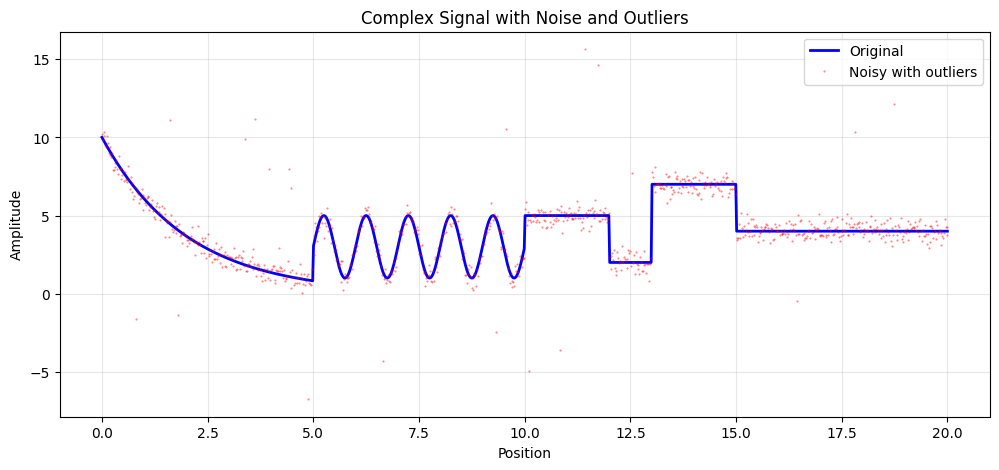

In [2]:
# Create a complex signal
x = np.linspace(0, 20, 1000)
signal = np.zeros_like(x)

# Different regions
signal[x < 5] = 10 * np.exp(-0.5 * x[x < 5])  # Exponential decay
signal[(x >= 5) & (x < 10)] = 3 + 2 * np.sin(2 * np.pi * x[(x >= 5) & (x < 10)])  # Oscillations
signal[(x >= 10) & (x < 15)] = SignalGenerator.step_function(
    x[(x >= 10) & (x < 15)] - 10, [(2, 5), (3, 2), (4, 7)]
)  # Steps
signal[x >= 15] = 4  # Constant

# Add noise and outliers
noise = NoiseGenerator.gaussian(signal.shape, snr_db=20, signal_power=np.mean(signal**2), seed=42)
noisy = signal + noise

# Add outliers
outlier_indices = np.random.choice(len(noisy), size=20, replace=False)
noisy[outlier_indices] += np.random.choice([-1, 1], size=20) * np.random.uniform(5, 10, size=20)

plt.figure(figsize=(12, 5))
plt.plot(x, signal, 'b-', linewidth=2, label='Original')
plt.plot(x, noisy, 'r.', markersize=1, alpha=0.5, label='Noisy with outliers')
plt.legend()
plt.xlabel('Position')
plt.ylabel('Amplitude')
plt.title('Complex Signal with Noise and Outliers')
plt.grid(True, alpha=0.3)
plt.show()

## 2. Compare Filtering Methods

In [4]:
# Standard SCSA
scsa_standard = SCSA1D(gmma=0.5)
result_standard = scsa_standard.filter_with_optimal_h(noisy)

# Adaptive SCSA
scsa_adaptive = AdaptiveSCSA(base_gmma=0.5)
result_adaptive = scsa_adaptive.denoise(noisy, adapt_h=True, adapt_gmma=True)

# Robust SCSA
scsa_robust = RobustSCSA(gmma=0.5, outlier_threshold=3.0)
result_robust = scsa_robust.denoise(noisy, handle_outliers=True)

print('Performance Comparison:')
print(f'Standard SCSA - MSE: {result_standard.metrics["mse"]:.6f}, PSNR: {result_standard.metrics["psnr"]:.2f} dB')
print(f'Adaptive SCSA - MSE: {result_adaptive.metrics["mse"]:.6f}, PSNR: {result_adaptive.metrics["psnr"]:.2f} dB')
print(f'Robust SCSA   - MSE: {result_robust.metrics["mse"]:.6f}, PSNR: {result_robust.metrics["psnr"]:.2f} dB')

Optimizing h parameter in the range: 2.2312418872050293 to 156.40231658855018
Optimizing h parameter in the range: 2.669567233622047 to 223.8884032245737
Optimizing h parameter in the range: 2.323965816391866 to 169.67167374247072
Performance Comparison:
Standard SCSA - MSE: 0.128201, PSNR: 32.81 dB
Adaptive SCSA - MSE: 0.080183, PSNR: 37.96 dB
Robust SCSA   - MSE: 0.005146, PSNR: 47.48 dB


## 3. Visualize Comparisons

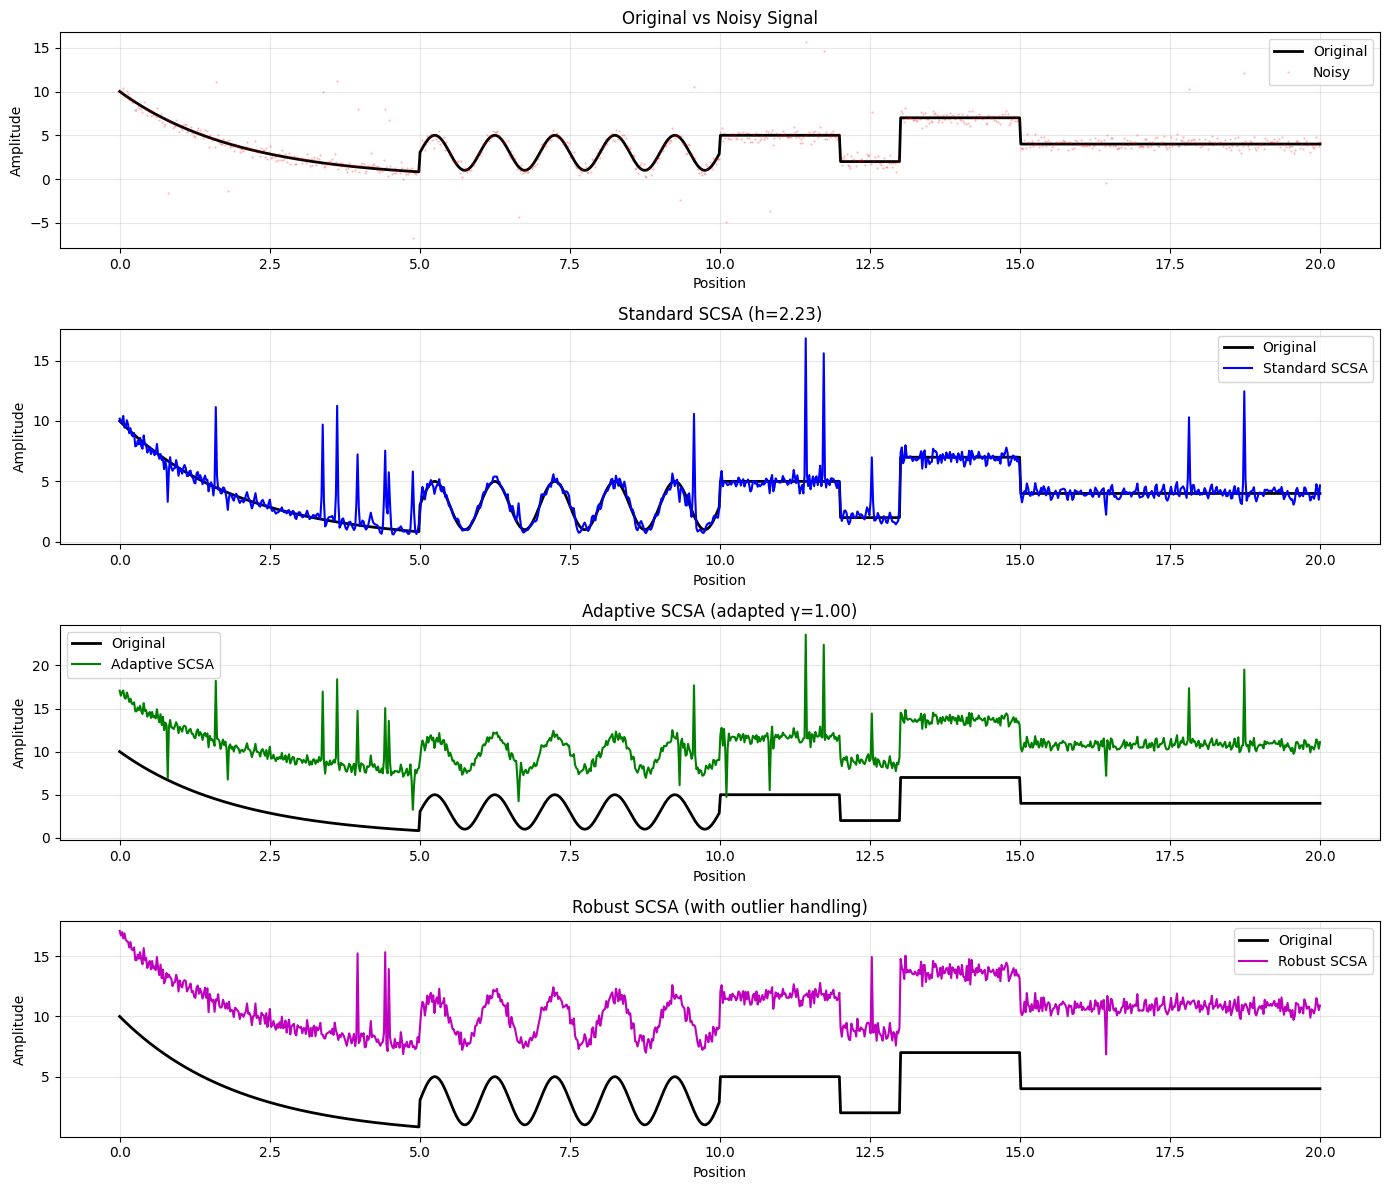

In [6]:
fig, axes = plt.subplots(4, 1, figsize=(14, 12))

# Original and noisy
axes[0].plot(x, signal, 'k-', linewidth=2, label='Original')
axes[0].plot(x, noisy, 'r.', markersize=1, alpha=0.3, label='Noisy')
axes[0].set_title('Original vs Noisy Signal')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Standard SCSA
axes[1].plot(x, signal, 'k-', linewidth=2, label='Original')
axes[1].plot(x, result_standard.reconstructed, 'b-', linewidth=1.5, label='Standard SCSA')
axes[1].set_title(f'Standard SCSA (h={result_standard.optimal_h:.2f})')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Adaptive SCSA
axes[2].plot(x, signal, 'k-', linewidth=2, label='Original')
axes[2].plot(x, result_adaptive.reconstructed, 'g-', linewidth=1.5, label='Adaptive SCSA')
axes[2].set_title(f'Adaptive SCSA (adapted γ={scsa_adaptive.scsa1d.gmma:.2f})')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

# Robust SCSA
axes[3].plot(x, signal, 'k-', linewidth=2, label='Original')
axes[3].plot(x, result_robust.reconstructed, 'm-', linewidth=1.5, label='Robust SCSA')
axes[3].set_title('Robust SCSA (with outlier handling)')
axes[3].legend()
axes[3].grid(True, alpha=0.3)

for ax in axes:
    ax.set_xlabel('Position')
    ax.set_ylabel('Amplitude')

plt.tight_layout()
plt.show()